<a href="https://colab.research.google.com/github/pacomm5/COVID-19/blob/master/cluster_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
# Hide unnecessary warnings
import warnings
warnings.filterwarnings('ignore')
# Clustering
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
pd.plotting.register_matplotlib_converters()

In [2]:
# con esto clonamos el github. tarda un rato mas menos 10 minutos. Entiendo que no ocupa memoria 

!git clone https://github.com/CSSEGISandData/COVID-19.git

Cloning into 'COVID-19'...
remote: Enumerating objects: 281908, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 281908 (delta 24), reused 37 (delta 19), pack-reused 281866
Receiving objects: 100% (281908/281908), 3.41 GiB | 12.83 MiB/s, done.
Resolving deltas: 100% (225768/225768), done.
Checking out files: 100% (1640/1640), done.


Cada fila representa un área FIPS en una provincia/estado de los Estados Unidos. Las columnas contienen el aumento acumulado de muertes por COVID-19 del 22 de enero de 2020 al 6 de junio de 2020.

In [34]:
# importamos los datos 
data = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")
data.head()


,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,...,12/28/21,12/29/21,12/30/21,12/31/21,1/1/22,1/2/22,1/3/22,1/4/22,1/5/22,1/6/22,1/7/22,1/8/22,1/9/22,1/10/22,1/11/22,1/12/22,1/13/22,1/14/22,1/15/22,1/16/22,1/17/22,1/18/22,1/19/22,1/20/22,1/21/22,1/22/22,1/23/22,1/24/22,1/25/22,1/26/22,1/27/22,1/28/22,1/29/22,1/30/22,1/31/22,2/1/22,2/2/22,2/3/22,2/4/22,2/5/22
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",55869,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,160,160,160,160,160,160,160,161,161,161,162,162,162,162,162,162,162,162,162,163,163,163,163,163,163,163,163,163,165,163,163,166,166,166,166,167,168,168,170,170
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",223234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,593,593,593,593,593,593,593,594,594,598,601,603,603,603,603,603,603,603,603,605,605,605,605,607,608,608,608,608,610,608,608,612,612,612,612,614,616,616,623,623
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",24686,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,81,81,81,81,81,81,81,81,81,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,84,83,83,84,84,84,84,84,85,85,85,85
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",22394,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,96,96,96,96,96,96,96,96
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",57826,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,197,198,198,198,198,198,198,198,198,198,199,202,202,202,202,202,202,202,202,203,203,203,203,204,204,204,204,204,206,204,204,207,207,207,207,207,208,208,210,210


Para examinar los datos, primero creamos datos agregados de series temporales a nivel de país.

In [35]:
us_ts = data.iloc[:,12:] # con esto sacamos todas las fechas, y los datos que contienen
us_ts = pd.DataFrame(us_ts.sum(axis=0)).reset_index() # con esto convertimos las columnas fechas a filas, y las ponemos como index. 
us_ts.columns = ["Date","NoOfCases"] # ponemos los nombres a las columnas 
us_ts["Date"] = pd.to_datetime(us_ts["Date"]) # convertimos la fecha a formato fecha. 
us_ts.set_index('Date', inplace=True)
us_ts.tail()

,NoOfCases
Date,
2022-02-01,891450
2022-02-02,894996
2022-02-03,897237
2022-02-04,901391
2022-02-05,902266


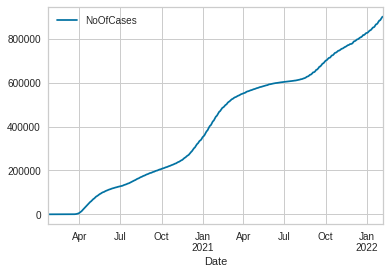

In [36]:
us_ts.plot()

ahora creamos los datos de series temporales por estado

In [ ]:
data_by_state = data.groupby("Province_State").agg(sum).reset_index() # agrupamos por estado
data_by_state = data_by_state.drop(columns=[’UID’, 'code3’, 'FIPS’, 'Lat’, 'Long_’, 'Population’])
data_by_state.head()

In [39]:
data_by_state = data.groupby("Province_State").agg(sum).reset_index()
data_by_state

,Province_State,UID,code3,FIPS,Lat,Long_,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,...,12/28/21,12/29/21,12/30/21,12/31/21,1/1/22,1/2/22,1/3/22,1/4/22,1/5/22,1/6/22,1/7/22,1/8/22,1/9/22,1/10/22,1/11/22,1/12/22,1/13/22,1/14/22,1/15/22,1/16/22,1/17/22,1/18/22,1/19/22,1/20/22,1/21/22,1/22/22,1/23/22,1/24/22,1/25/22,1/26/22,1/27/22,1/28/22,1/29/22,1/30/22,1/31/22,2/1/22,2/2/22,2/3/22,2/4/22,2/5/22
0,Alabama,5796241491,57960,241491.0,2203.246784,-5809.578199,4903185,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,16436,16454,16455,16455,16455,16455,16455,16496,16503,16543,16585,16624,16624,16624,16630,16641,16641,16641,16641,16734,16734,16734,16756,16792,16824,16826,16826,16826,16914,16826,16826,17047,17086,17086,17086,17146,17215,17215,17371,17371
1,Alaska,2772236473,27720,236473.0,1868.733025,-4605.860811,740995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,976,978,978,978,978,978,979,979,979,979,980,980,980,980,980,985,985,987,987,987,987,987,1051,1051,1051,1051,1051,1072,1072,1081,1081,1085,1085,1085,1085,1085,1093,1093,1093,1093
2,American Samoa,16,16,60.0,-14.271000,-170.132000,55641,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Arizona,1428230216,14280,230216.0,505.138555,-1671.948482,7278717,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,23982,24144,24171,24229,24354,24355,24355,24509,24570,24586,24616,24704,24773,24773,24986,24992,25002,25068,25068,25171,25212,25395,25416,25429,25502,25557,25623,25624,25624,25899,25932,26001,26183,26206,26205,26345,26369,26430,26530,26628
4,Arkansas,6468550635,64680,550635.0,2618.391704,-6932.548370,3017804,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,9097,9113,9131,9148,9180,9196,9221,9248,9256,9278,9298,9314,9314,9333,9358,9372,9390,9413,9430,9434,9437,9452,9462,9470,9484,9498,9510,9532,9556,9574,9596,9616,9616,9616,9628,9667,9690,9733,9762,9793
5,California,5040521376,50400,521376.0,2194.949775,-7002.258461,39512223,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,76255,76336,76437,76520,76520,76523,76540,76634,76760,76792,77026,77043,77056,77203,77226,77360,77507,77657,77723,77774,77938,78013,78101,78307,78482,78553,78616,78798,78887,79139,79400,79689,79764,79801,80044,80176,80497,80678,80917,81001
6,Colorado,5544685999,55440,685999.0,2491.870366,-6751.119357,5758736,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,10169,10198,10240,10271,10271,10271,10293,10335,10354,10402,10425,10425,10425,10466,10528,10552,10582,10614,10616,10616,10659,10662,10726,10768,10800,10799,10799,10847,10933,10953,11005,11061,11061,11061,11115,11164,11178,11194,11202,11202
7,Connecticut,840242082,8400,242082.0,332.909441,-581.254637,3565287,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,9156,9161,9160,9160,9160,9160,9210,9274,9281,9281,9377,9377,9377,9377,9435,9442,9442,9556,9556,9556,9554,9564,9670,9683,9769,9769,9769,9774,9773,9901,9908,9985,9985,9985,10010,10076,10083,10083,10159,10159
8,Delaware,420200029,4200,200029.0,117.327830,-226.599712,973764,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2276,2283,2286,2286,2286,2286,2286,2286,2286,2286,2330,2365,2365,2365,2373,2377,2380,2396,2424,2424,2424,2424,2440,2450,2457,2480,2480,2480,2489,2493,2494,2498,2531,2531,2531,2544,2552,2555,2563,2576
9,Diamond Princess,84088888,840,88888.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
